In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter
import mpmath
from fractions import Fraction
from math import floor
import pickle
import sympy as sp
from scipy.optimize import linprog

# General choice model

In [ ]:
all = {}
# compute E[T_{l1,..,lN}] given the assortment offered at the first step
def T_general(l, S, k, memory, assortment, proba):
    """Compute the total expected number of customer required to clear the stock,
    for a policy who offers first the assortment S until a product is selected by a customer, then it follows the optimal policy. 

    Args:
        l (list of integers): the current stock
        S (set): the first assortment offered to the customers, until a product is selected by a customer
        k (int): cardinality constraint
        memory (dictionary): dictionary, where the keys are the states of the stock
        assortment (dictionary): dictionary, where the keys are the states of the stock, and the values are the optimal assortment correponding to that stock.
        proba (dictionary) : dictionary, where the  keys are the feasible assortments, and the values are dictionaries,
        whose keys are elements of the feasible assortment and the values are the probability of choosing this element knowing that you show this assortment
        
    Returns:
        float: the total expected time
    """
    I_N = np.identity(len(l))
    T = Fraction(1,1)
    f_S = Fraction(0,1)
    if len(S) == 0:
        return Fraction(0,1)
    for i in S :
        f_S = f_S + proba[tuple(S)][i]
        if tuple(l - I_N[i]) in memory :
            Ti = memory[tuple(l - I_N[i])]
        else :
            Ti = f_general(l - I_N[i],k, memory, assortment, proba)[0]
        T = T + proba[tuple(S)][i] *Ti
    return T/f_S

# compute the subsets of the set of cardinality at most k
def generate_subsets_up_to_k_general(elements, k):
    """Generate a list of the subsets of elements, of cardinality at most k

    Args:
        elements (list): list of the products which are still in stock
        k (int): cardinality constraint

    Returns:
        list: list of the subsets of elements, of cardinality at most k
    """
    subsets = []
    n = len(elements)
    for i in range(1 << n):  # Nombre de sous-ensembles possibles = 2^n
        subset = [elements[j] for j in range(n) if (i & (1 << j))]
        if len(subset) <= k and len(subset) >= 1:
            subsets.append(subset)
    return subsets

# compute the feasible assortments
def set_assortments_general(l,k):
    """Return the list of the feasible assortments

    Args:
        l (list of int): current stock
        k (int): cardinality constraint

    Returns:
        list: list of the feasible assortments
    """
    N_assortment = [i for i in range(len(l)) if l[i] > 0]
    return generate_subsets_up_to_k_general(N_assortment, k)

# compute the assortment corresponding to the minimum, and the value of the minimum
def f_general(l, k, memory, assortment, proba) :
    """Return the optimal value, after exploring all the feasible solutions.

    Args:
        l (list of integers): the current stock
        k (int): cardinality constraint
        memory (dictionary): dictionary, where the keys are the states of the stock
        assortment (dictionary): dictionary, where the keys are the states of the stock, and the values are the optimal assortment correponding to that stock
        proba (dictionary) : dictionary, where the  keys are the feasible assortments, and the values are dictionaries,
        whose keys are elements of the feasible assortment and the values are the probability of choosing this element knowing that you show this assortment
        
    Returns:
        float or Fraction: optimal value
        list : optimal assortment
        dictionary : dictionary, where the keys are the states of the stock
        dictionary: dictionary, where the keys are the states of the stock, and the values are the optimal assortment correponding to that stock

    """
    if tuple(l) in memory :
        return memory[tuple(l)], assortment[tuple(l)], memory, assortment
    S_set = set_assortments_general(l,k)
    S_min = []
    T_min = float('inf')
    all[tuple(l)] = {}
    for S in S_set :
        T_s = T_general(l, S, k, memory, assortment, proba)
        all[tuple(l)][tuple(S)] = T_s
        if T_s < T_min or (T_s == T_min and len(S_min)<len(S)):
            T_min = T_s
            S_min = S
    assortment[tuple(l)] = S_min
    memory[tuple(l)] = T_min
    return T_min, S_min, memory, assortment

def solution_opt_general(l,k, proba, memory, assortment):
    """Return the dictionaries corresponding to the optimal solution

    Args:
        l (list of integers): the current stock
        k (int): cardinality constraint
        proba (dictionary) : dictionary, where the  keys are the feasible assortments, and the values are dictionaries,
        whose keys are elements of the feasible assortment and the values are the probability of choosing this element knowing that you show this assortment
        memory (dictionary): dictionary, where the keys are the states of the stock
        assortment (dictionary): dictionary, where the keys are the states of the stock, and the values are the optimal assortment correponding to that stock
        
    Returns:
        dictionary : dictionary, where the keys are the states of the stock
        dictionary: dictionary, where the keys are the states of the stock, and the values are the optimal assortment correponding to that stock.
    """
    N = len(l)
    if tuple([0 for i in range(N)]) not in memory : #initialization of the dictionaries
        memory[tuple([0 for i in range(N)])] = Fraction(0,1)
        assortment[tuple([0 for i in range(N)])] = []
    memory[tuple([0 for i in range(N)])] = Fraction(0,1)
    assortment[tuple([0 for i in range(N)])] = []
    if np.sum(l) == 0 :
        return Fraction(0,1),[]
    return f_general(l,k, memory, assortment, proba)[2:4]

## Nested Logit

In [ ]:
def list_subsets(ensemble):
    """Return the list of the subsets of ensemble

    Args:
        ensemble (list): list of elements

    Returns:
        list: list of the subsets of ensemble
    """
    sous_ensembles = []
    for taille in range(len(ensemble) + 1):
        for combinaison in itertools.combinations(ensemble, taille):
            sous_ensembles.append(set(combinaison))
    return sous_ensembles

In [ ]:
def NL_proba(i, S, set, list_v, v0, gamma):
    """Return the dictionary of the probabilities for the Nested Logit Model

    Args:
        i (int): product, element of set
        S (list of list): list of the nests
        set (list): assortment
        list_v (list): list of the preference weights, without the no-purchase
        v0 (float): preference wieght of the no-purchase
        gamma (float): dissimilarity parameter

    Returns:
        dictionary : dictionary of the probabilities for the Nested Logit Model
    """
    S0 = [[k for k in S[j] if k in set] for j in range(len(S))]
    S2 = [tab for tab in S0 if len(tab)>0]
    v = [Fraction(0,1) for l in range(len(S2))]
    pos = 0
    for j in range(len(S2)):
        if i in S2[j]:
            pos = j
        for k in range(len(S2[j])):
            v[j] = v[j] + list_v[S2[j][k]]
    v_puissance_gamma = np.zeros(len(v))
    for k in range(len(v)):
        v_puissance_gamma[k] = v[k] ** (gamma[S2[k][0]])
    return list_v[i]/(v[pos]) * v_puissance_gamma[pos] /(v0 + np.sum(v_puissance_gamma)) # this is the probability without no-purchase among a nest

In [ ]:
list_v = [1,2,10]
v0 = Fraction(1,1)
gamma = [0.5,0.5,0.5]
S = [[0,1],[2]]
proba = {}
ensemble = {0, 1, 2}
sous_ensembles = list_subsets(ensemble)
for sous_ensemble in sous_ensembles:
    if len(sous_ensemble) >0:
        proba[tuple(sous_ensemble)] = {}
        for i in sous_ensemble:
            proba[tuple(sous_ensemble)][i] = NL_proba(i,S, sous_ensemble, list_v, v0, gamma)

In [ ]:
memory = {}
assortment = {}

In [ ]:
# If you modify the preference weights, you need to reset the dictionaries
list_l = [10,10,10]
memory, assortment = solution_opt_general(list_l,2, proba, memory, assortment)

## Markov Chain

In [ ]:
def list_subsets(ensemble):
    """Return the list of the subsets of ensemble

    Args:
        ensemble (list): list of elements

    Returns:
        list: list of the subsets of ensemble
    """
    sous_ensembles = []
    for taille in range(len(ensemble) + 1):
        for combinaison in itertools.combinations(ensemble, taille):
            sous_ensembles.append(set(combinaison))
    return sous_ensembles

def MC_proba(i, sous_ensemble, ensemble, lambda_proba, P):
    """Return the probability under the Markov Chain choice model : P(i|S)

    Args:
        i (int): product
        sous_ensemble (list): assortment shown
        ensemble (set): set of products
        lambda_proba (list): arrival probabilities
        P (matrix): matrix of the transition probabilities

    Returns:
        float: probability under the Markov Chain choice model : P(i|S)
    """
    complementaire = ensemble - sous_ensemble
    id = sp.eye(len(complementaire))
    P2 = P[:,1:]
    index = list(sous_ensemble).index(i) # position de i dans le sous-ensemble
    B = P2[list(complementaire), :][:,list(sous_ensemble)]
    C = P2[list(complementaire), :][:,list(complementaire)]
    if len(complementaire) > 0:
        new_vector = sp.Matrix([lambda_proba[i] for i in complementaire])
        return lambda_proba[i] + (new_vector.T * (id - C).inv()* B)[index]
    else :
        return lambda_proba[i]

In [ ]:
lambda_proba = sp.Matrix([Fraction(1,2),Fraction(1,2),Fraction(0,10)]) # arrival probabilities
P = sp.Matrix([
    [Fraction(0,1), Fraction(0,1), Fraction(0,1),Fraction(1,1)],
    [Fraction(0,1), Fraction(0,1), Fraction(0,1),Fraction(1,1)],
    [Fraction(1,1),Fraction(0,1),Fraction(0,1),Fraction(0,1)]
]) # transition probabilities, each line = starting product, each column = arrival product 

proba = {} # dictionary of the probabilities
ensemble = {0, 1, 2}
sous_ensembles = list_subsets(ensemble)
for sous_ensemble in sous_ensembles:
    if len(sous_ensemble) >0:
        proba[tuple(sous_ensemble)] = {}
        for i in sous_ensemble:
            proba[tuple(sous_ensemble)][i] = MC_proba(i, sous_ensemble, ensemble, lambda_proba, P)

In [ ]:
memory = {}
assortment = {}

In [ ]:
# If you modify the preference weights, you need to reset the dictionaries
list_l = [10,10,10]
memory, assortment = solution_opt_general(list_l,2, proba, memory, assortment)

## MMNL

In [ ]:
def list_subsets(ensemble):
    """Return the list of the subsets of ensemble

    Args:
        ensemble (list): list of elements

    Returns:
        list: list of the subsets of ensemble
    """
    sous_ensembles = []
    for taille in range(len(ensemble) + 1):
        for combinaison in itertools.combinations(ensemble, taille):
            sous_ensembles.append(set(combinaison))
    return sous_ensembles

def MMNL_proba(i, sous_ensemble, theta, V):
    """Return the probability of choosing i knowing that you show sous_ensemble : P(i|S)

    Args:
        i (int): product
        sous_ensemble (list): assortment shown
        theta (list): probabilities of each segment
        V (matrix): matrix of the preference weights. Each line = 1 product, each column = 1 segment

    Returns:
        float or Fraction: probability of choosing i knowing that you show sous_ensemble : P(i|S)
    """
    return np.dot(np.array(theta).T, V[i,:]/(1+np.sum(V[list(sous_ensemble), :], axis = 0)))

In [ ]:
theta = [Fraction(5,10),Fraction(5,10)] # probabilities of each segment

V = np.array([
    [Fraction(5,1), Fraction(5,1)],
    [Fraction(1,1), Fraction(1,4)],
    [Fraction(1,4), Fraction(1,1)]
]) #matrix of the preference weights. Each line = 1 product, each column = 1 segment
proba = {}
ensemble = {0, 1, 2}
sous_ensembles = list_subsets(ensemble)
for sous_ensemble in sous_ensembles:
    if len(sous_ensemble) >0:
        proba[tuple(sous_ensemble)] = {}
        for i in sous_ensemble:
            proba[tuple(sous_ensemble)][i] = MMNL_proba(i, sous_ensemble, theta, V)

In [ ]:
memory = {}
assortment = {}

In [ ]:
list_l = [10,10,10]
memory, assortment = solution_opt_general(list_l,2, proba, memory, assortment)

## Visualization of the probabilities

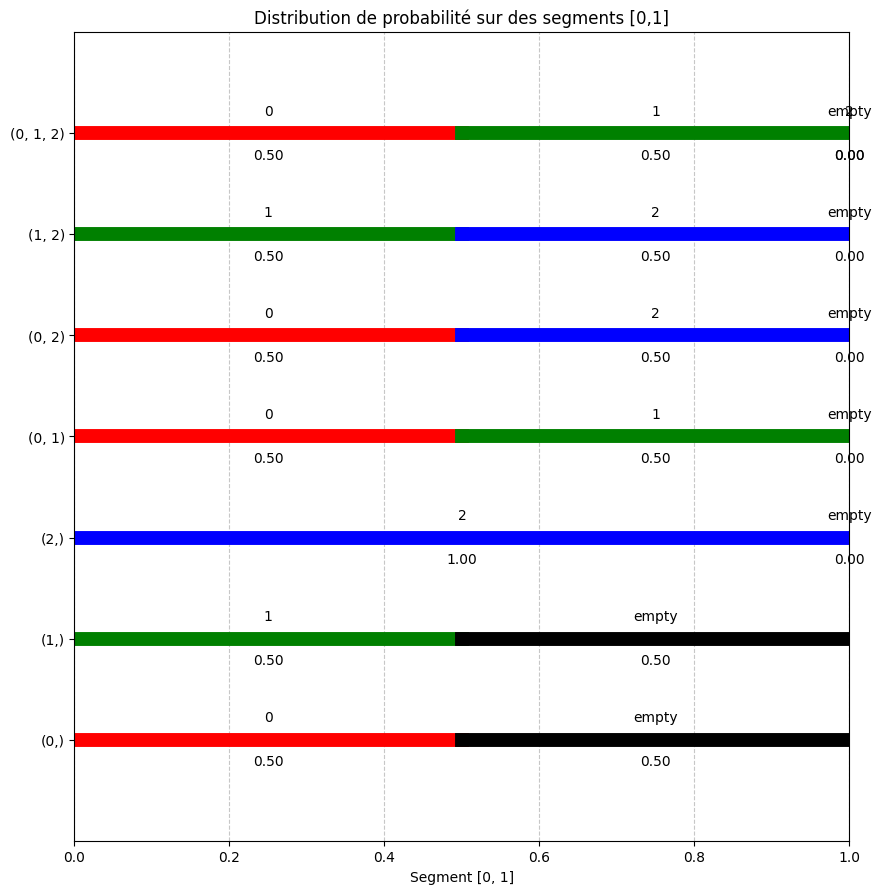

In [ ]:
def plot_probability_distribution_subset(probs_dict):
    """"
    Displays a probability distribution on segments [0,1] for subsets of {0, 1, 2}. FOR 3 PRODUCTS ONLY

    Args:
    probs_dict (dict): A dictionary where the keys are subsets of {0, 1, 2}
                       (as tuples) and values are dictionaries representing the probabilities
                       the probabilities associated with each element in this subset.
    """
    # Définir les couleurs pour chaque objet
    colors = {0: 'red', 1: 'green', 2: 'blue',3 :'grey', 'empty': 'black'}
    
    # Ajouter l'ensemble vide à chaque sous-ensemble manquant
    for subset in probs_dict:
        if 'empty' not in probs_dict[subset]:
            probs_dict[subset]['empty'] = Fraction(1) - sum(probs_dict[subset].values())
    
    # Création de la figure et des axes
    fig, ax = plt.subplots(figsize=(10, len(probs_dict) * 1.5))
    
    # Plot each subset on a separate line
    for idx, (subset, sub_probs) in enumerate(probs_dict.items()):
        start = Fraction(0)
        # Crée un segment pour chaque élément dans le sous-ensemble
        for obj, prob in sub_probs.items():
            end = start + prob
            mid = start + prob / 2
            ax.plot([float(start), float(end)], [idx, idx], color=colors[obj], lw=10)
            ax.text(mid, idx + 0.15, f'{obj}', ha='center', va='bottom', color='black', fontsize=10)
            ax.text(mid, idx - 0.15, f'{float(prob):.2f}', ha='center', va='top', color='black', fontsize=10)
            start = end
    
    # Ajouter les labels et ajuster l'affichage
    ax.set_xlim(0, 1)
    ax.set_ylim(-1, len(probs_dict))
    ax.set_yticks(range(len(probs_dict)))
    ax.set_yticklabels([str(subset) for subset in probs_dict.keys()])
    ax.set_xlabel('Segment [0, 1]')
    ax.set_title('Distribution de probabilité sur des segments [0,1]')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_probability_distribution_subset(proba)